In [1]:
from google.cloud import bigquery
import os

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "geocode-345718-d1551db2f8c6.json"

In [3]:
# Create a BigQuery client
client = bigquery.Client()

In [4]:
# Define your SQL query
query = """
SELECT
  u.id AS user_id,
  u.age,
  u.gender,
  u.city,
  u.traffic_source,
  oi.order_id,
  oi.status,
  oi.product_id,
  ini.product_category,
  ini.product_name,
  ini.product_retail_price,
  ini.cost,  
  oi.sale_price,  
  oi.returned_at,  
  e.event_type,  
  dc.name AS dc_name,
  dc.latitude AS d_lat,
  dc.longitude AS d_long,
  u.latitude AS u_lat,
  u.longitude AS u_long,
  (6371 * ACOS(
    COS(u.latitude * 3.141592653589793 / 180) *
    COS(dc.latitude * 3.141592653589793 / 180) *
    COS((dc.longitude - u.longitude) * 3.141592653589793 / 180) +
    SIN(u.latitude * 3.141592653589793 / 180) *
    SIN(dc.latitude * 3.141592653589793 / 180)
  )) AS dc2c_distance,
  oi.created_at,
  oi.shipped_at,
  oi.delivered_at,
  TIMESTAMP_DIFF(oi.shipped_at, oi.created_at, MINUTE) AS prep_time,
  TIMESTAMP_DIFF(oi.delivered_at, oi.shipped_at, MINUTE) AS delivery_time,
  TIMESTAMP_DIFF(oi.shipped_at, oi.created_at, MINUTE) + TIMESTAMP_DIFF(oi.delivered_at, oi.shipped_at, MINUTE) AS total_time,
  o.num_of_item  -- Add num_of_item from orders table

FROM `bigquery-public-data.thelook_ecommerce.users` AS u
JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi ON u.id = oi.user_id
JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` AS ini ON oi.inventory_item_id = ini.id
JOIN `bigquery-public-data.thelook_ecommerce.orders` AS o ON oi.order_id = o.order_id  -- Join orders table for num_of_item
JOIN `bigquery-public-data.thelook_ecommerce.events` AS e ON e.user_id = u.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.distribution_centers` AS dc ON ini.product_distribution_center_id = dc.id

WHERE
  u.country = 'United States'
  AND EXTRACT(YEAR FROM u.created_at) >= EXTRACT(YEAR FROM DATE_SUB(CURRENT_DATE(), INTERVAL 1 YEAR))
  AND (oi.status = 'Returned' OR oi.status = 'Complete');
"""

# Execute the query
query_job = client.query(query)

In [5]:
# Convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Display the results
df.head()

,user_id,age,gender,city,traffic_source,order_id,status,product_id,product_category,product_name,...,u_lat,u_long,dc2c_distance,created_at,shipped_at,delivered_at,prep_time,delivery_time,total_time,num_of_item
0,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,33.396167,-111.716792,2003.686896,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1
1,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,33.396167,-111.716792,2003.686896,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1
2,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,33.396167,-111.716792,2003.686896,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1
3,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,33.396167,-111.716792,2003.686896,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1
4,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,33.396167,-111.716792,2003.686896,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1


In [6]:
df.columns

Index(['user_id', 'age', 'gender', 'city', 'traffic_source', 'order_id',
       'status', 'product_id', 'product_category', 'product_name',
       'product_retail_price', 'cost', 'sale_price', 'returned_at',
       'event_type', 'dc_name', 'd_lat', 'd_long', 'u_lat', 'u_long',
       'dc2c_distance', 'created_at', 'shipped_at', 'delivered_at',
       'prep_time', 'delivery_time', 'total_time', 'num_of_item'],
      dtype='object')

In [7]:
initial_shape = df.shape
df.drop_duplicates(inplace=True)
final_shape = df.shape
print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows.")

Removed 110498 duplicate rows.


In [8]:
df.shape

(22556, 28)

In [9]:
timestamp_cols = ['returned_at', 'created_at', 'shipped_at', 'delivered_at']
for col in timestamp_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted column '{col}' to datetime.")

# Verify data types after conversion
print("Data Types after Conversion:")
df.dtypes

Converted column 'returned_at' to datetime.
Converted column 'created_at' to datetime.
Converted column 'shipped_at' to datetime.
Converted column 'delivered_at' to datetime.
Data Types after Conversion:


user_id                               Int64
age                                   Int64
gender                               object
city                                 object
traffic_source                       object
order_id                              Int64
status                               object
product_id                            Int64
product_category                     object
product_name                         object
product_retail_price                float64
cost                                float64
sale_price                          float64
returned_at             datetime64[ns, UTC]
event_type                           object
dc_name                              object
d_lat                               float64
d_long                              float64
u_lat                               float64
u_long                              float64
dc2c_distance                       float64
created_at              datetime64[ns, UTC]
shipped_at              datetime

# Present Reality of the Business Based on the Data

In [10]:
num_unique_customers = df['user_id'].nunique()
total_orders = df['order_id'].nunique()
total_returns = df['returned_at'].notnull().sum()

In [11]:
df['revenue'] = df['sale_price'] - df['cost']
total_revenue = df['revenue'].sum()

In [12]:
total_items_sold = df['num_of_item'].sum()

In [13]:
summary = {
    'Number of Unique Customers': np.int64(num_unique_customers),
    'Total Orders': np.int64(total_orders),
    'Total Returns': np.int64(total_returns),
    'Total Revenue': np.float64(total_revenue),
    'Total Items Sold': np.int64(total_items_sold)
}

In [14]:
summary_converted = {
    'Number of Unique Customers': int(summary['Number of Unique Customers']),
    'Total Orders': int(summary['Total Orders']),
    'Total Returns': int(summary['Total Returns']),
    'Total Revenue': float(summary['Total Revenue']),
    'Total Items Sold': int(summary['Total Items Sold'])
}

# Print the converted summary
summary_converted

{'Number of Unique Customers': 2740,
 'Total Orders': 3274,
 'Total Returns': 6789,
 'Total Revenue': 670850.8489163402,
 'Total Items Sold': 42106}

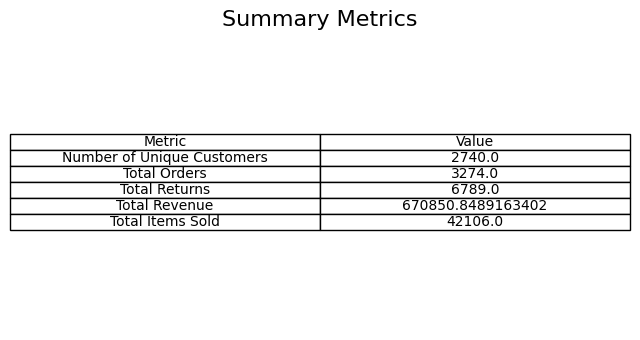

In [15]:
# Convert summary to a new format
summary_converted = {
    'Number of Unique Customers': int(summary['Number of Unique Customers']),
    'Total Orders': int(summary['Total Orders']),
    'Total Returns': int(summary['Total Returns']),
    'Total Revenue': float(summary['Total Revenue']),
    'Total Items Sold': int(summary['Total Items Sold'])
}

# Create a DataFrame from the summary_converted
summary_df = pd.DataFrame(list(summary_converted.items()), columns=['Metric', 'Value'])

# Create a table plot
plt.figure(figsize=(8, 4))
plt.title('Summary Metrics', fontsize=16)

# Create the table
plt.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)

# Hide the axes
plt.axis('off')

# Adjust layout to reduce space between title and table
plt.subplots_adjust(top=0.85)

# Show the table
plt.show()

In [16]:
return_rate = total_returns / total_items_sold

In [17]:
return_rate

0.1612359283712535

In [18]:
repeat_customers = df.groupby('user_id')['order_id'].nunique() > 1
repeat_purchase_rate = repeat_customers.sum() / df['user_id'].nunique()

In [19]:
returned_revenue = df.loc[df['returned_at'].notnull(), 'revenue'].sum()
total_revenue = df['revenue'].sum()
revenue_loss_from_returns = returned_revenue / total_revenue

In [20]:
total_sales_value = df['sale_price'].sum()
percentage_of_sales_reversed = (returned_revenue / total_sales_value) * 100

In [21]:
repeat_returners = df[df['returned_at'].notnull()].groupby('user_id')['order_id'].nunique() > 1
percentage_repeat_returners = (repeat_returners.sum() / df['user_id'].nunique()) * 100

In [22]:
summary_metrics = {
    'Return Rate': np.float64(return_rate),
    'Repeat Purchase Rate': np.float64(repeat_purchase_rate),
    'Revenue Loss from Returns': np.float64(revenue_loss_from_returns),
    'Percentage of Sales Reversed': np.float64(percentage_of_sales_reversed),
    'Percentage of Repeat Returners': np.float64(percentage_repeat_returners)
}

In [23]:
summary_metrics_converted = {key: float(value) for key, value in summary_metrics.items()}
summary_metrics_converted

{'Return Rate': 0.1612359283712535,
 'Repeat Purchase Rate': 0.16678832116788322,
 'Revenue Loss from Returns': 0.29669963782706255,
 'Percentage of Sales Reversed': 15.391675226076595,
 'Percentage of Repeat Returners': 1.9708029197080292}

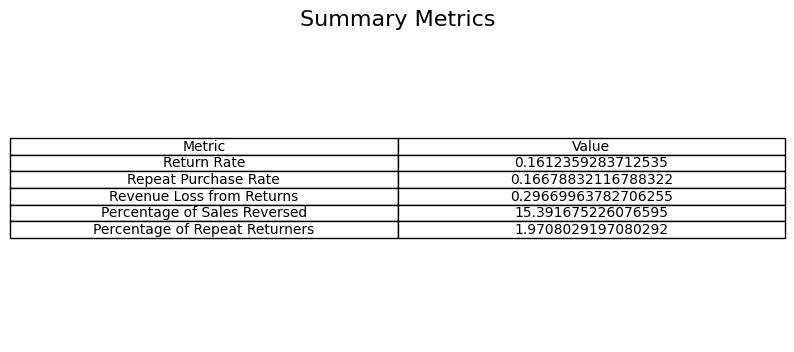

In [24]:
# Create a DataFrame from the summary metrics
summary_df = pd.DataFrame(list(summary_metrics_converted.items()), columns=['Metric', 'Value'])

# Create a table plot
plt.figure(figsize=(10, 4))
plt.title('Summary Metrics', fontsize=16)

# Create a table
plt.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)

# Hide axes
plt.axis('off')


# Show the table
plt.show()

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create binary status column
df['status_binary'] = df['status'].apply(lambda x: 1 if x == 'Returned' else 0)

# Create a copy and set the index
df1 = df.copy()
df1.set_index('returned_at', inplace=True)


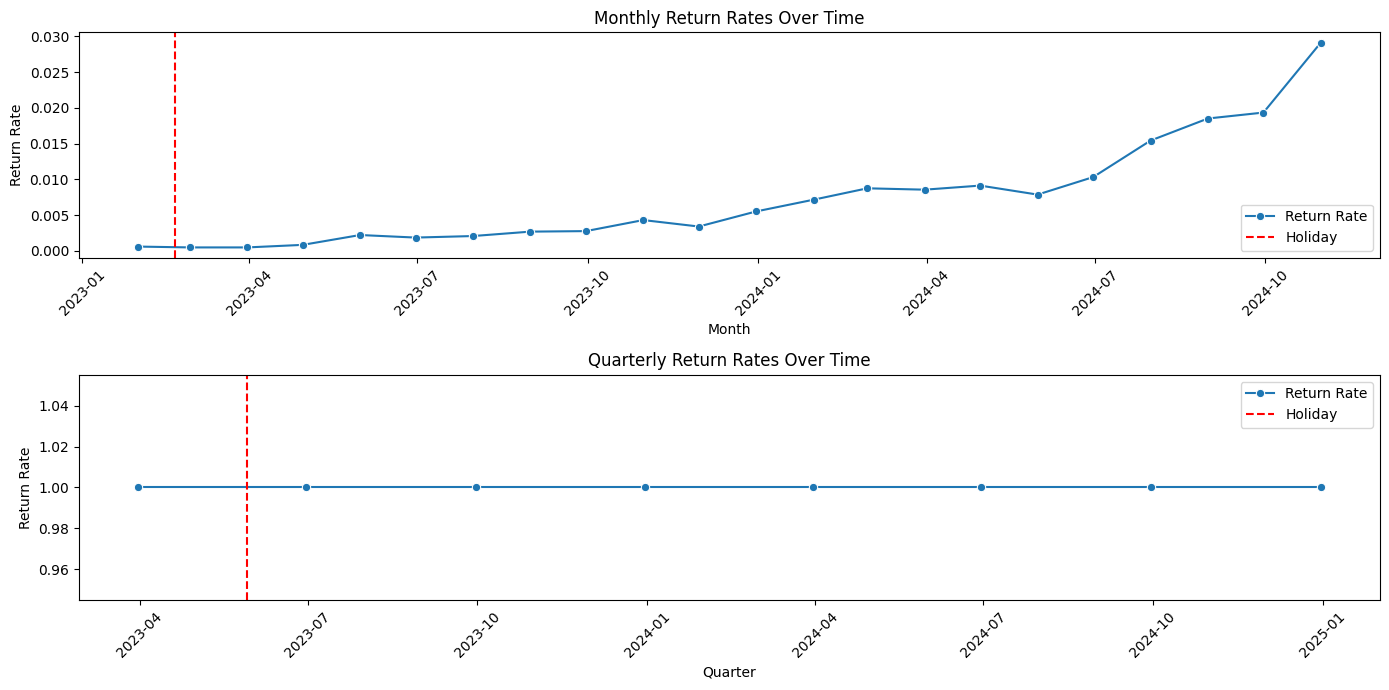

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create a holiday calendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df1.index.min(), end=df1.index.max())

# Calculate total returns and total items
total_returns = df1['status_binary'].resample('M').sum()  # Total returns per month
total_items = df1['status_binary'].resample('M').count()  # Total items per month

# Calculate return rate as total returns / total_items_sold
monthly_return_rate = total_returns / total_items_sold

# Convert holidays to DatetimeIndex
holidays = pd.to_datetime(holidays)

# Plotting monthly return rates
plt.figure(figsize=(14, 7))

# Monthly return rates
plt.subplot(2, 1, 1)
sns.lineplot(data=monthly_return_rate, marker='o', label='Return Rate')

# Check for the next holiday and plot it
next_holiday = holidays[holidays >= monthly_return_rate.index.min()].min()
plt.axvline(x=next_holiday, color='red', linestyle='--', label='Holiday')

plt.title('Monthly Return Rates Over Time')
plt.xlabel('Month')
plt.ylabel('Return Rate')
plt.xticks(rotation=45)
plt.legend()

# Quarterly return rates
total_returns_quarterly = df1['status_binary'].resample('Q').sum()
total_items_quarterly = df1['status_binary'].resample('Q').count()
quarterly_return_rate = total_returns_quarterly / total_items_quarterly

plt.subplot(2, 1, 2)
sns.lineplot(data=quarterly_return_rate, marker='o', label='Return Rate')

# Check for the next holiday and plot it
next_holiday_quarterly = holidays[holidays >= quarterly_return_rate.index.min()].min()
plt.axvline(x=next_holiday_quarterly, color='red', linestyle='--', label='Holiday')

plt.title('Quarterly Return Rates Over Time')
plt.xlabel('Quarter')
plt.ylabel('Return Rate')
plt.xticks(rotation=45)
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Example age bins
labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']  # Corresponding labels

# Create a new column for age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df.head()

,user_id,age,gender,city,traffic_source,order_id,status,product_id,product_category,product_name,...,created_at,shipped_at,delivered_at,prep_time,delivery_time,total_time,num_of_item,revenue,status_binary,age_group
0,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1,6.47352,0,55-64
1,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1,6.47352,0,55-64
2,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1,6.47352,0,55-64
3,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1,6.47352,0,55-64
4,96170,56,M,Mesa,Search,120309,Complete,29047,Accessories,100% Cowhide Leather Black Leather Belt Snap o...,...,2024-04-22 05:12:17+00:00,2024-04-25 02:36:00+00:00,2024-04-28 20:23:00+00:00,4163,5387,9550,1,6.47352,0,55-64


In [28]:
# Filter the DataFrame for customers who returned products
returns_df = df[df['returned_at'].notnull()]

# Group by age_group, gender, city, and product category
segment_analysis_returns = returns_df.groupby(['age_group', 'gender', 'city', 'product_category']).agg({
    'order_id': 'nunique',  # Total unique orders (for those who returned)
    'returned_at': 'count',  # Total returns
    'revenue': 'sum',  # Total revenue generated (before return)
    'num_of_item': 'sum'  # Total items sold (for those who returned)
}).reset_index()


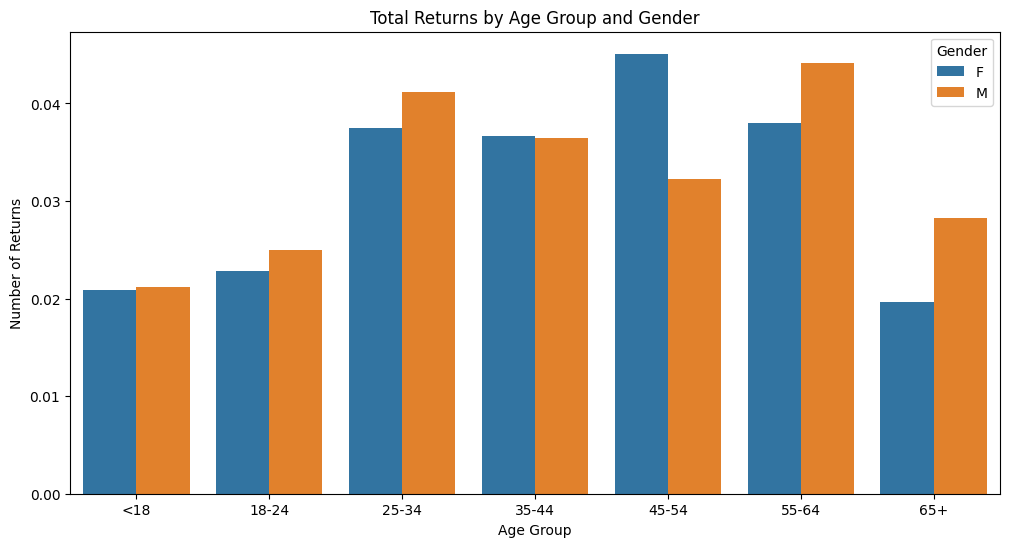

In [29]:
# Bar chart: Total Returns by Age Group and Gender
plt.figure(figsize=(12, 6))
sns.barplot(data=segment_analysis_returns, x='age_group', y='returned_at', hue='gender', ci=None)

# Add titles and labels
plt.title('Total Returns by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Number of Returns')
plt.legend(title='Gender')

# Show plot
plt.show()

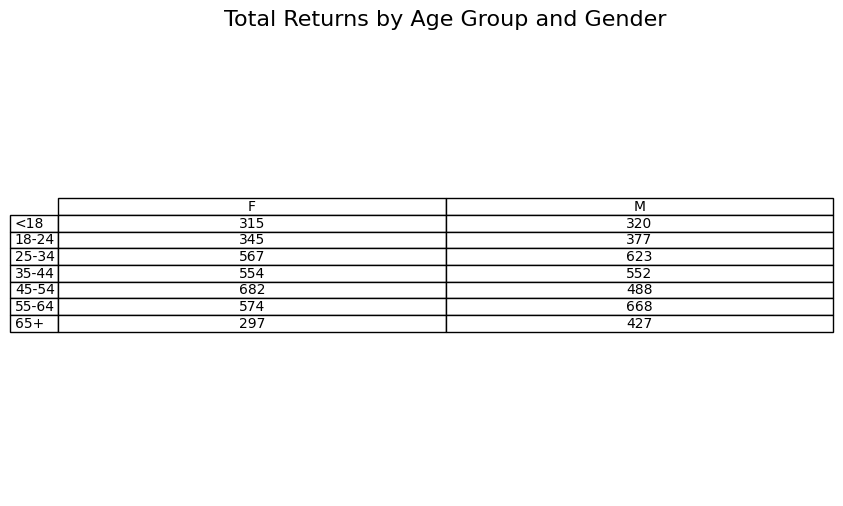

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a summary DataFrame
table_data = segment_analysis_returns.groupby(['age_group', 'gender'])['returned_at'].sum().unstack().fillna(0)

# Create a table plot
plt.figure(figsize=(10, 6))
plt.title('Total Returns by Age Group and Gender', fontsize=16)

# Create a table
plt.table(cellText=table_data.values,
          colLabels=table_data.columns,
          rowLabels=table_data.index,
          cellLoc='center',
          loc='center')

# Hide axes
plt.axis('off')

# Show the table
plt.show()

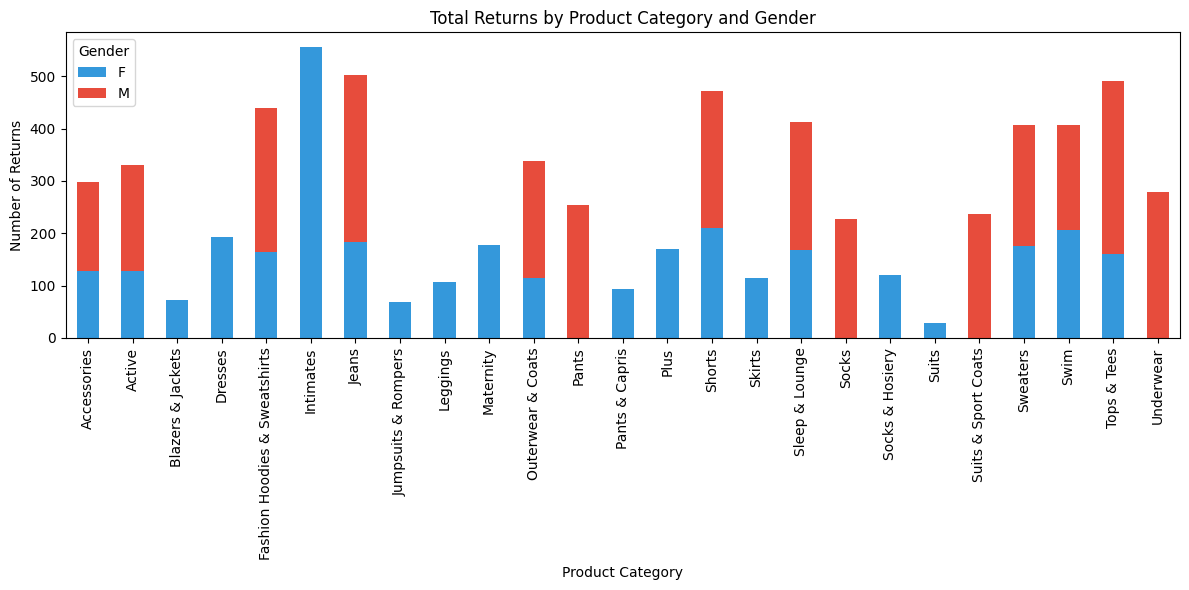

In [31]:
# Pivot the data for stacked bar chart
pivot_data = segment_analysis_returns.pivot_table(index='product_category', columns='gender', values='returned_at', aggfunc='sum').fillna(0)

# Plot stacked bar chart
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#3498db', '#e74c3c'])

# Add titles and labels
plt.title('Total Returns by Product Category and Gender')
plt.xlabel('Product Category')
plt.ylabel('Number of Returns')
plt.legend(title='Gender')

# Show plot
plt.tight_layout()
plt.show()

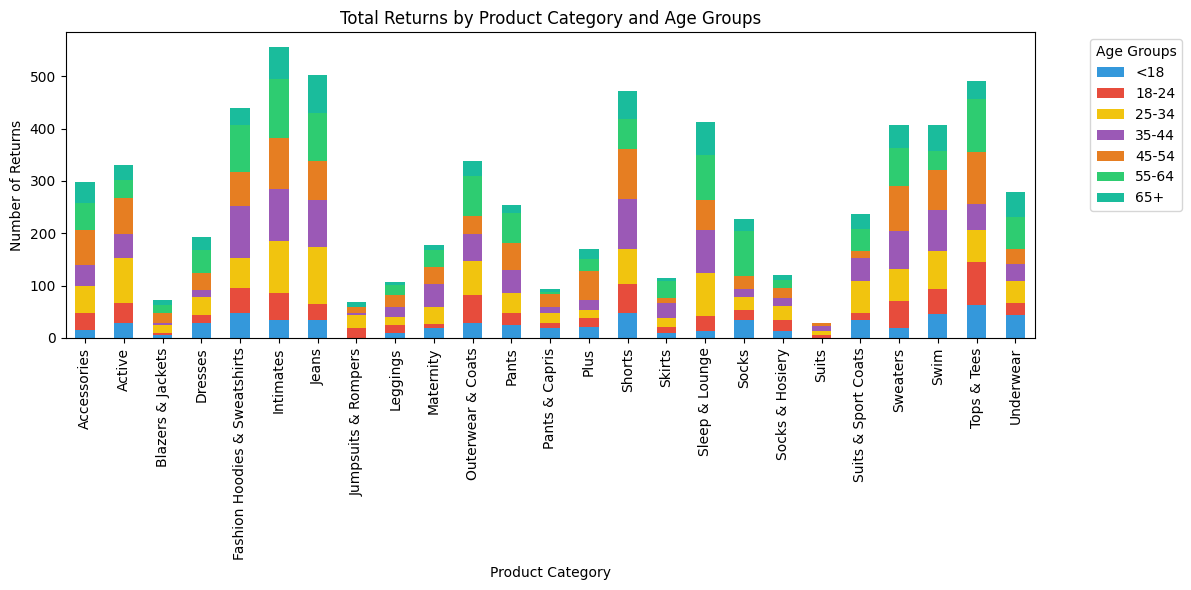

In [32]:
import matplotlib.pyplot as plt

# Pivot the data for stacked bar chart
pivot_data = segment_analysis_returns.pivot_table(index='product_category', columns='age_group', values='returned_at', aggfunc='sum').fillna(0)

# Define colors for 7 age groups
colors = ['#3498db', '#e74c3c', '#f1c40f', '#9b59b6', '#e67e22', '#2ecc71', '#1abc9c']  # Add more colors if needed

# Plot stacked bar chart
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Add titles and labels
plt.title('Total Returns by Product Category and Age Groups')
plt.xlabel('Product Category')
plt.ylabel('Number of Returns')
plt.legend(title='Age Groups', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position if needed

# Show plot
plt.tight_layout()
plt.show()

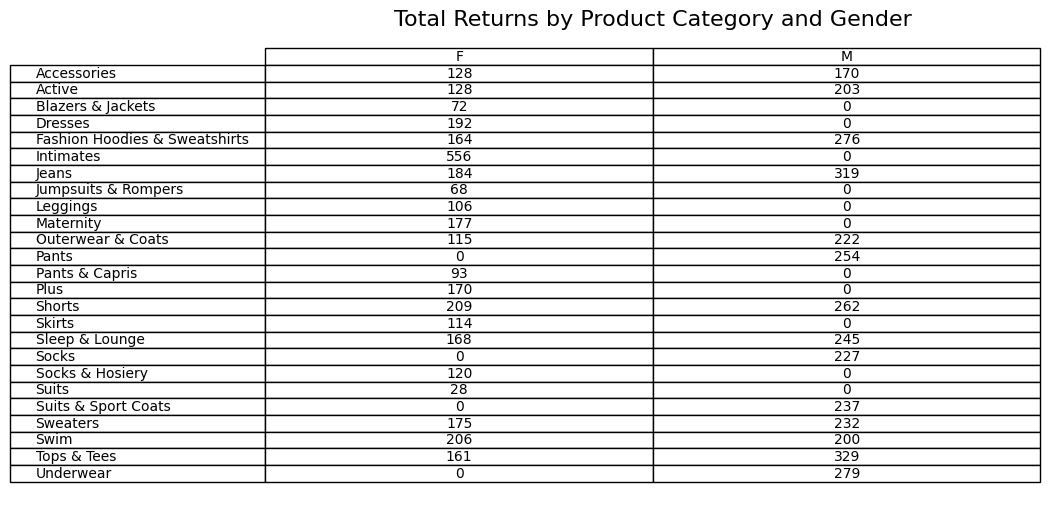

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Pivot the data for table visualization
pivot_data = segment_analysis_returns.pivot_table(
    index='product_category', 
    columns='gender', 
    values='returned_at', 
    aggfunc='sum'
).fillna(0)

# Create a table plot
plt.figure(figsize=(10, 6))
plt.title('Total Returns by Product Category and Gender', fontsize=16)

# Create a table
plt.table(
    cellText=pivot_data.values,
    colLabels=pivot_data.columns,
    rowLabels=pivot_data.index,
    cellLoc='center',
    loc='center'
)

# Hide axes
plt.axis('off')

# Show the table
plt.show()


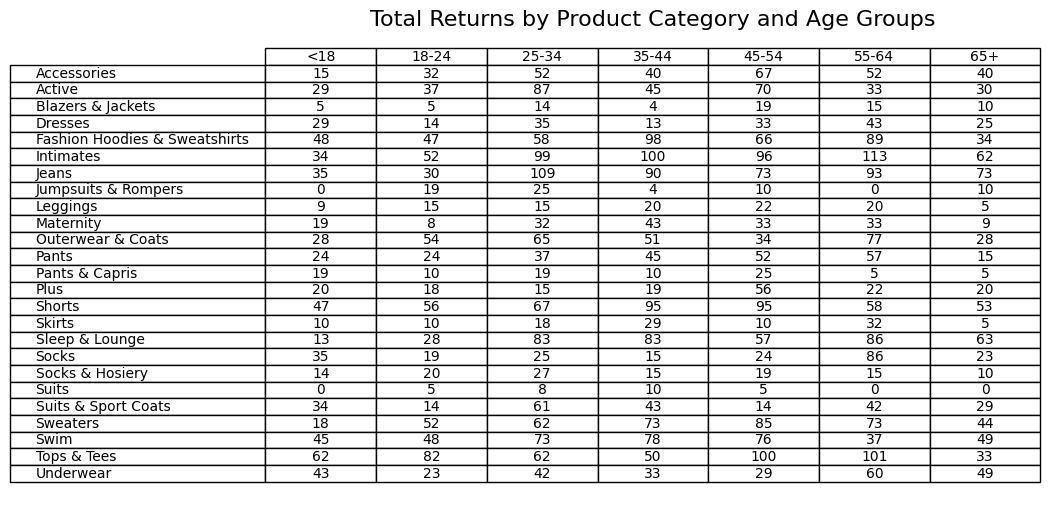

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Pivot the data for table visualization
pivot_data = segment_analysis_returns.pivot_table(
    index='product_category', 
    columns='age_group', 
    values='returned_at', 
    aggfunc='sum'
).fillna(0)

# Create a table plot
plt.figure(figsize=(10, 6))
plt.title('Total Returns by Product Category and Age Groups', fontsize=16)

# Create a table
plt.table(
    cellText=pivot_data.values,
    colLabels=pivot_data.columns,
    rowLabels=pivot_data.index,
    cellLoc='center',
    loc='center'
)

# Hide axes
plt.axis('off')

# Show the table
plt.show()


In [35]:
segment_analysis_returns['returned_at'] = segment_analysis_returns['returned_at'].astype(int)
segment_analysis_returns['revenue'] = segment_analysis_returns['revenue'].astype(float)
segment_analysis_returns['num_of_item'] = segment_analysis_returns['num_of_item'].astype(int)

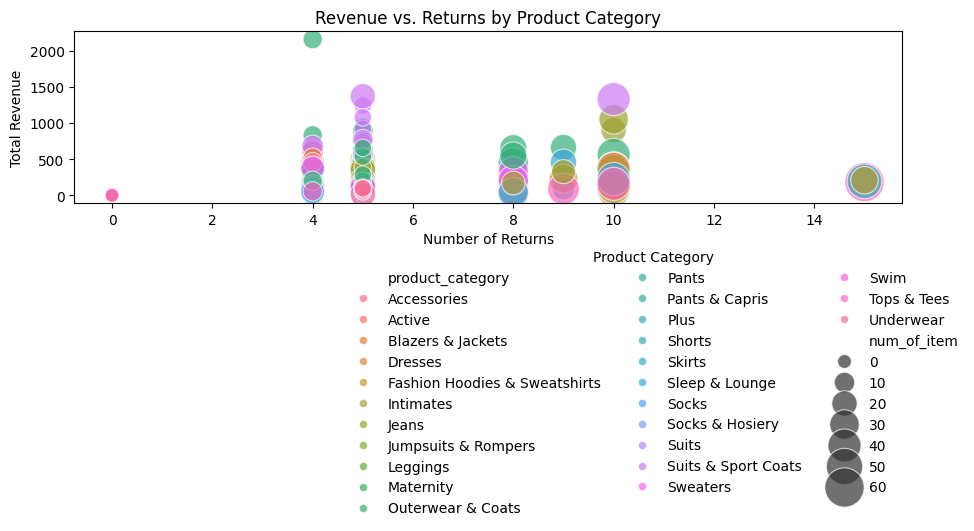

In [36]:
plt.figure(figsize=(10, 6))

# Scatter plot: Revenue vs Returns by Product Category
sns.scatterplot(data=segment_analysis_returns, 
                x='returned_at', 
                y='revenue', 
                hue='product_category', 
                size='num_of_item', 
                sizes=(100, 800),  # Increased sizes for larger scatter points
                alpha=0.7)

# Add titles and labels
plt.title('Revenue vs. Returns by Product Category')
plt.xlabel('Number of Returns')
plt.ylabel('Total Revenue')

# Adjust the legend to be horizontal below the scatter plot
plt.legend(title='Product Category', bbox_to_anchor=(0.7, -0.2), loc='upper center', ncol=3, frameon=False)


# Show plot
plt.tight_layout()
plt.show()

# Why That Is Happening?

In [37]:
import pandas as pd
import statsmodels.api as sm

# Prepare the data
df['status_binary'] = df['status'].apply(lambda x: 1 if x == 'Returned' else 0)

for column in ['gender', 'city', 'product_category']:
    df[column] = df[column].astype('category').cat.codes

In [38]:
# Select treatment, outcome, and confounders
X = df[['delivery_time', 'age', 'gender', 'city', 'product_category',
         'product_retail_price', 'num_of_item', 'revenue', 'dc2c_distance']]
y = df['status_binary']


In [39]:
# Convert nullable Int64 to standard int
X['delivery_time'] = X['delivery_time'].astype('int')
X['age'] = X['age'].astype('int')
X['num_of_item'] = X['num_of_item'].astype('int')

In [40]:
print(X.dtypes)

delivery_time             int32
age                       int32
gender                     int8
city                      int16
product_category           int8
product_retail_price    float64
num_of_item               int32
revenue                 float64
dc2c_distance           float64
dtype: object


In [41]:
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Summary of the results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.610043
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          status_binary   No. Observations:                22556
Model:                          Logit   Df Residuals:                    22546
Method:                           MLE   Df Model:                            9
Date:                Mon, 07 Oct 2024   Pseudo R-squ.:                0.002702
Time:                        07:11:44   Log-Likelihood:                -13760.
converged:                       True   LL-Null:                       -13797.
Covariance Type:            nonrobust   LLR p-value:                 1.932e-12
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0922      0.068    -16.080      0.000      -1.225      -0.959

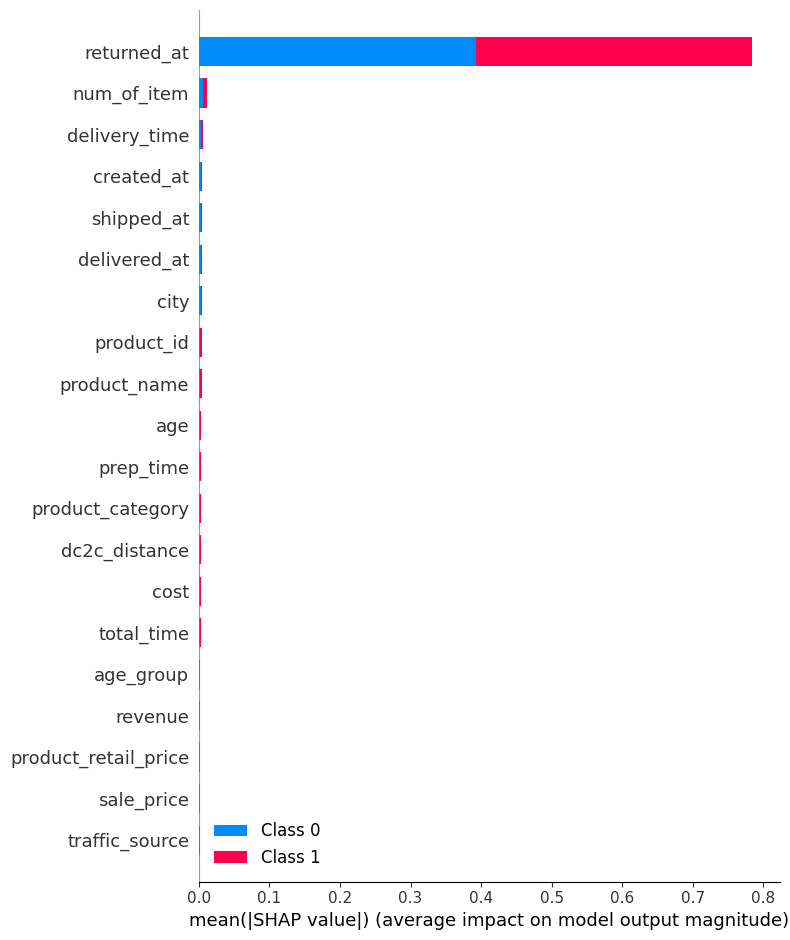

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import shap


categorical_columns = ['traffic_source', 'event_type', 'dc_name', 'age_group', 'product_name']

label_encoder = LabelEncoder()

datetime_columns = ['created_at', 'shipped_at', 'delivered_at', 'returned_at']  # List your datetime columns

# Convert datetime to timestamp (seconds since epoch)
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce')  # Ensure proper datetime format
    df[column] = df[column].astype('int64') // 10**9  # Convert to seconds (or milliseconds if needed)

# Apply Label Encoding
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column].astype(str))  # Convert to string to handle any potential NaN


X = df.drop(columns=['status', 'user_id', 'order_id', 'd_long', 'd_lat','u_lat', 'u_long','status_binary'])  
y = df['status_binary']  # Binary target

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

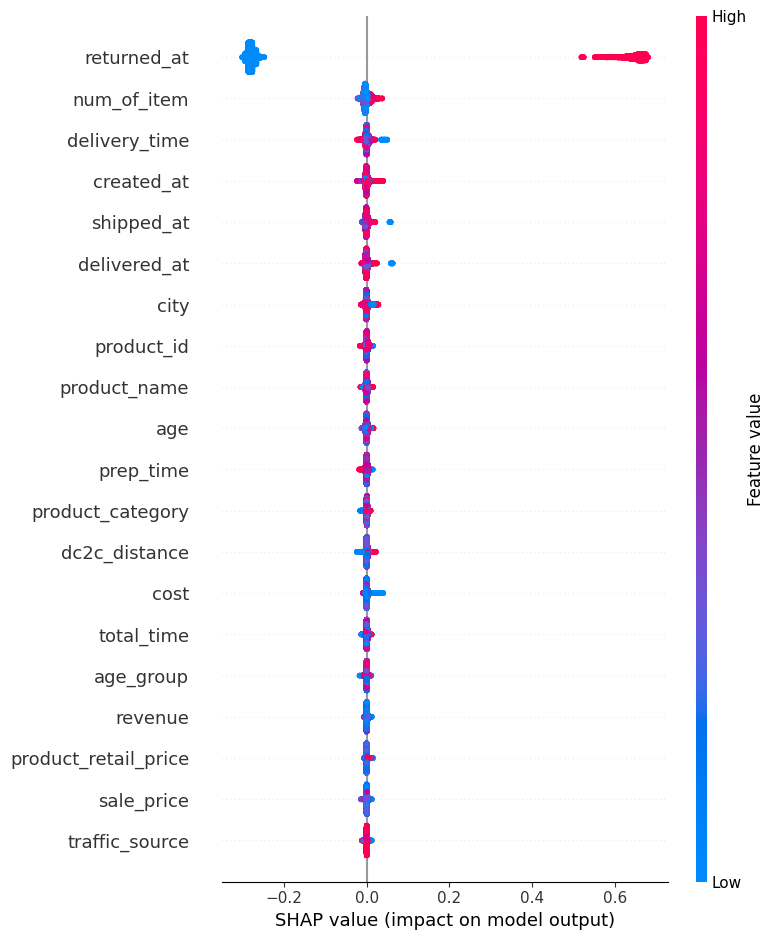

In [43]:
import matplotlib.pyplot as plt

# Get SHAP values for class 1 (Returned)
shap_values_class_1 = shap_values[1]  # Select SHAP values for class 1 (Returned)

# Create the SHAP summary plot for the top 20 features
shap.summary_plot(shap_values_class_1, X, feature_names=X.columns, max_display=20)

# Save the plot as a PNG file
plt.savefig('shap_summary_class_1.png', dpi=300, bbox_inches='tight')

# Optional: close the plot to prevent it from displaying inline in notebooks
plt.close()

In [45]:
shap.summary_plot(shap_values_class_1, X, feature_names=X.columns, max_display=20, show=False)
plt.savefig('shap_summary_class_1.png', dpi=300, bbox_inches='tight')
plt.close()

In [44]:
import pandas as pd

# Get SHAP values for class 1 (Returned)
shap_values_class_1 = shap_values[1]  # Select SHAP values for class 1 (Returned)

# Create a DataFrame of SHAP values for class 1
shap_df = pd.DataFrame(shap_values_class_1, columns=X.columns)

# Calculate the mean absolute SHAP value for each feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

# Convert to DataFrame for easier viewing
shap_table = pd.DataFrame(shap_mean).reset_index()
shap_table.columns = ['Feature', 'Mean Absolute SHAP Value']

# Display the top 20 features
shap_table_top_20 = shap_table.head(20)

# Display the table
shap_table_top_20

,Feature,Mean Absolute SHAP Value
0,returned_at,0.392316
1,num_of_item,0.005747
2,delivery_time,0.003067
3,created_at,0.002489
4,shipped_at,0.002403
5,delivered_at,0.002279
6,city,0.002172
7,product_id,0.001857
8,product_name,0.001838
9,age,0.001726
